In [2]:
!pip install fredapi

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
pip install pmdarima

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 101.6 MB/s eta 0:00:00

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from fredapi import Fred
import calendar
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.gridspec as gridspec

In [6]:
fred = Fred(api_key="")
unemp = fred.get_series('CGBD2024')

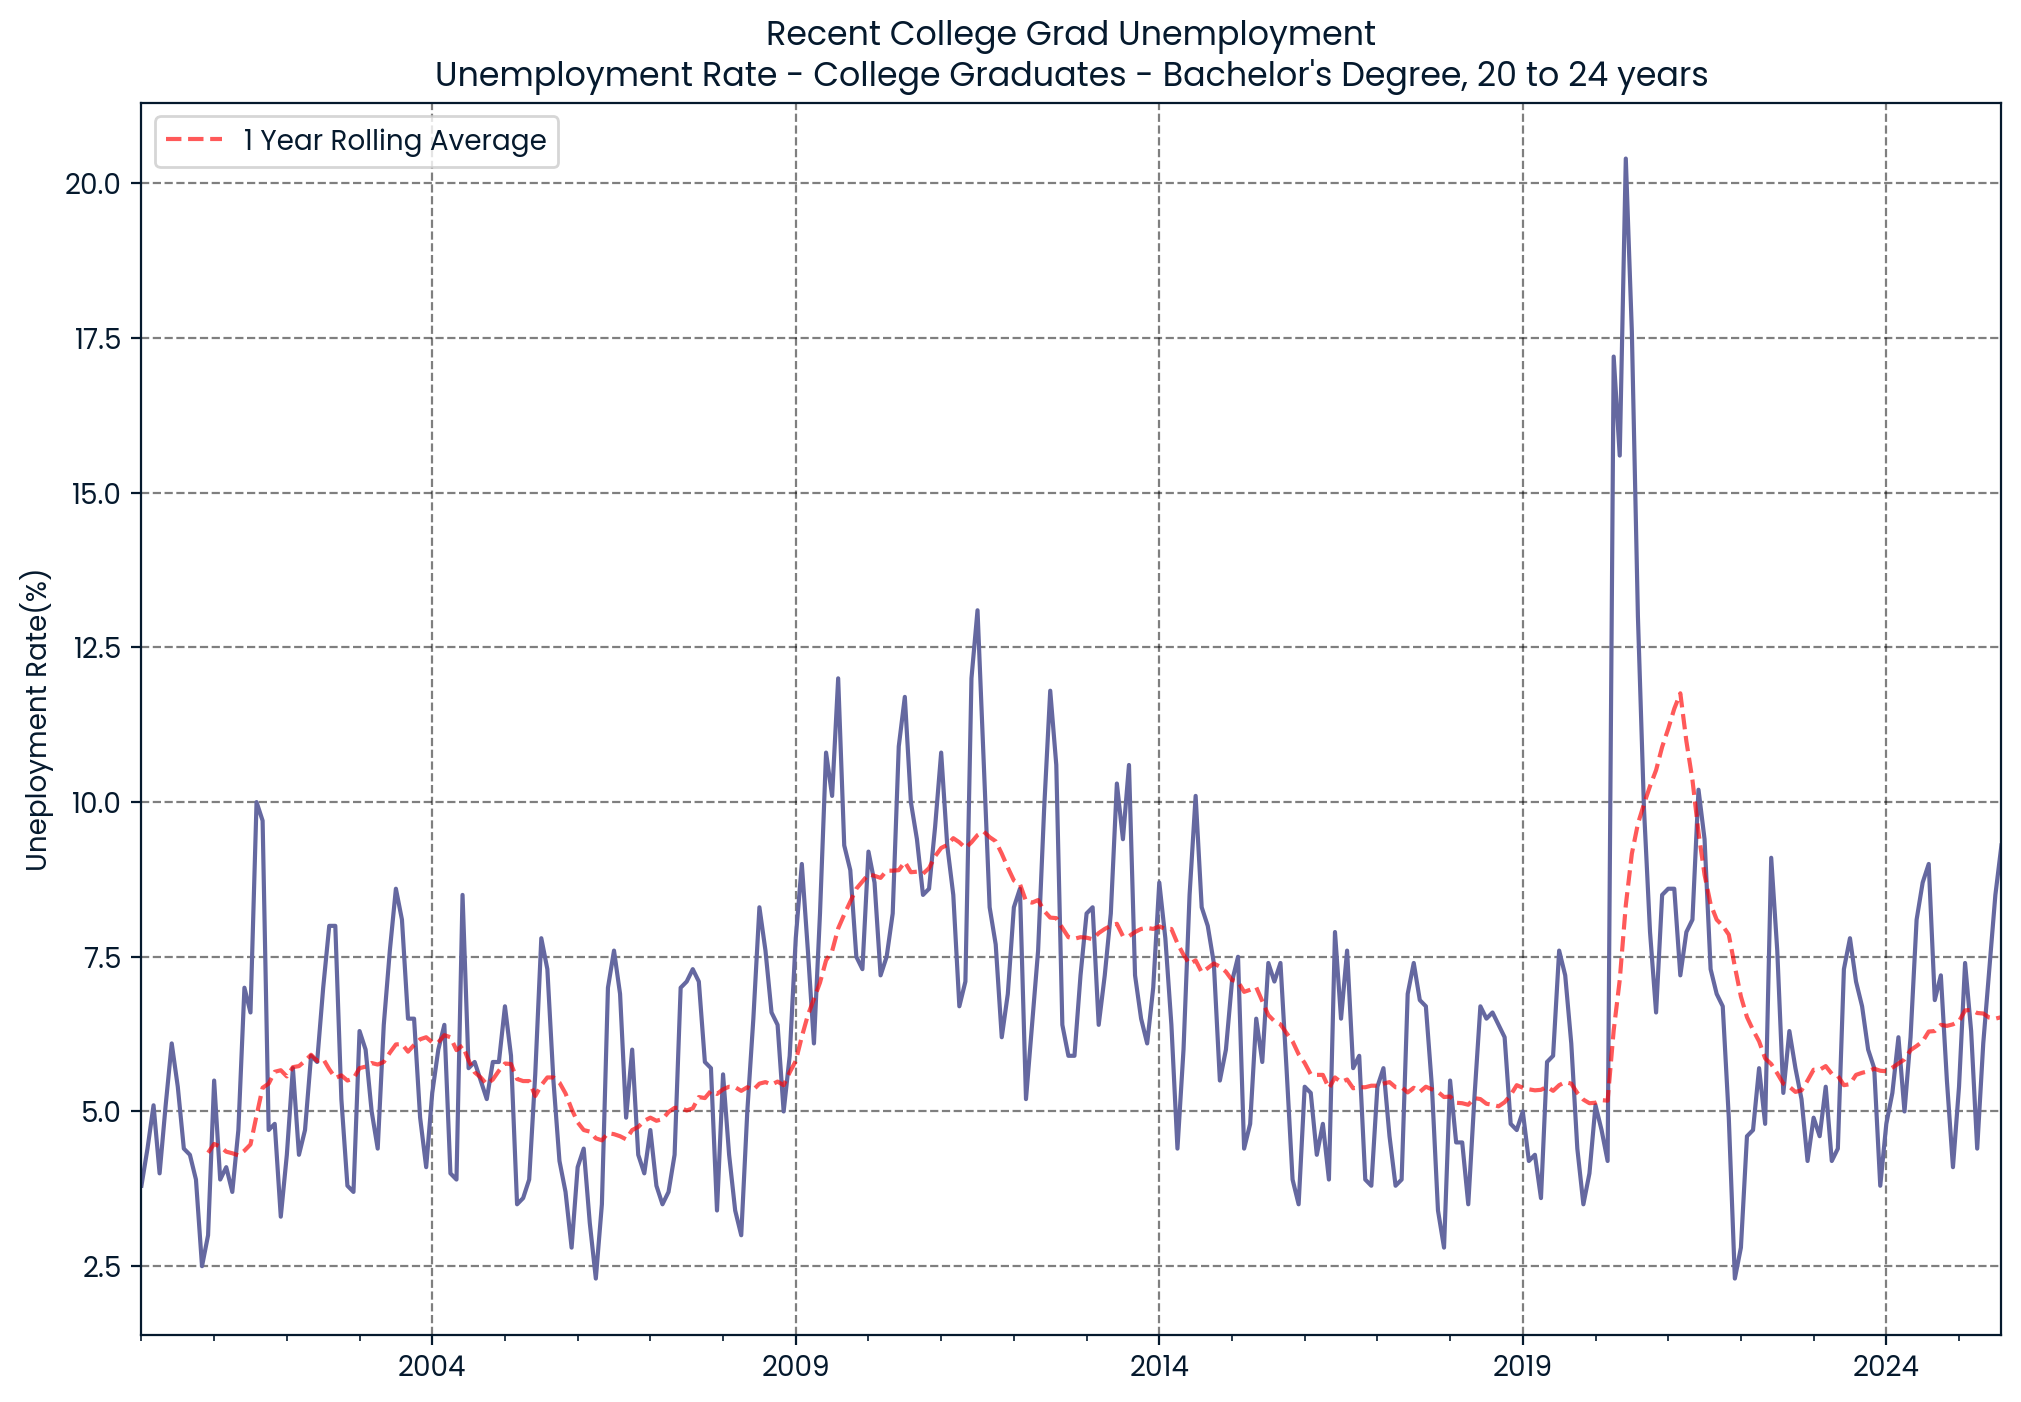

In [7]:
# Plot Series
plt.figure(figsize=(12, 8))
unemp.plot()
unemp.rolling(window=12).mean().plot(label = '1 Year Rolling Average', linestyle = '--', alpha=0.65, color ='r')
plt.grid(alpha =0.5, color='k', linestyle ='--')
plt.title("Recent College Grad Unemployment\nUnemployment Rate - College Graduates - Bachelor's Degree, 20 to 24 years")
plt.ylabel("Uneployment Rate(%)")
plt.legend()


plt.show()

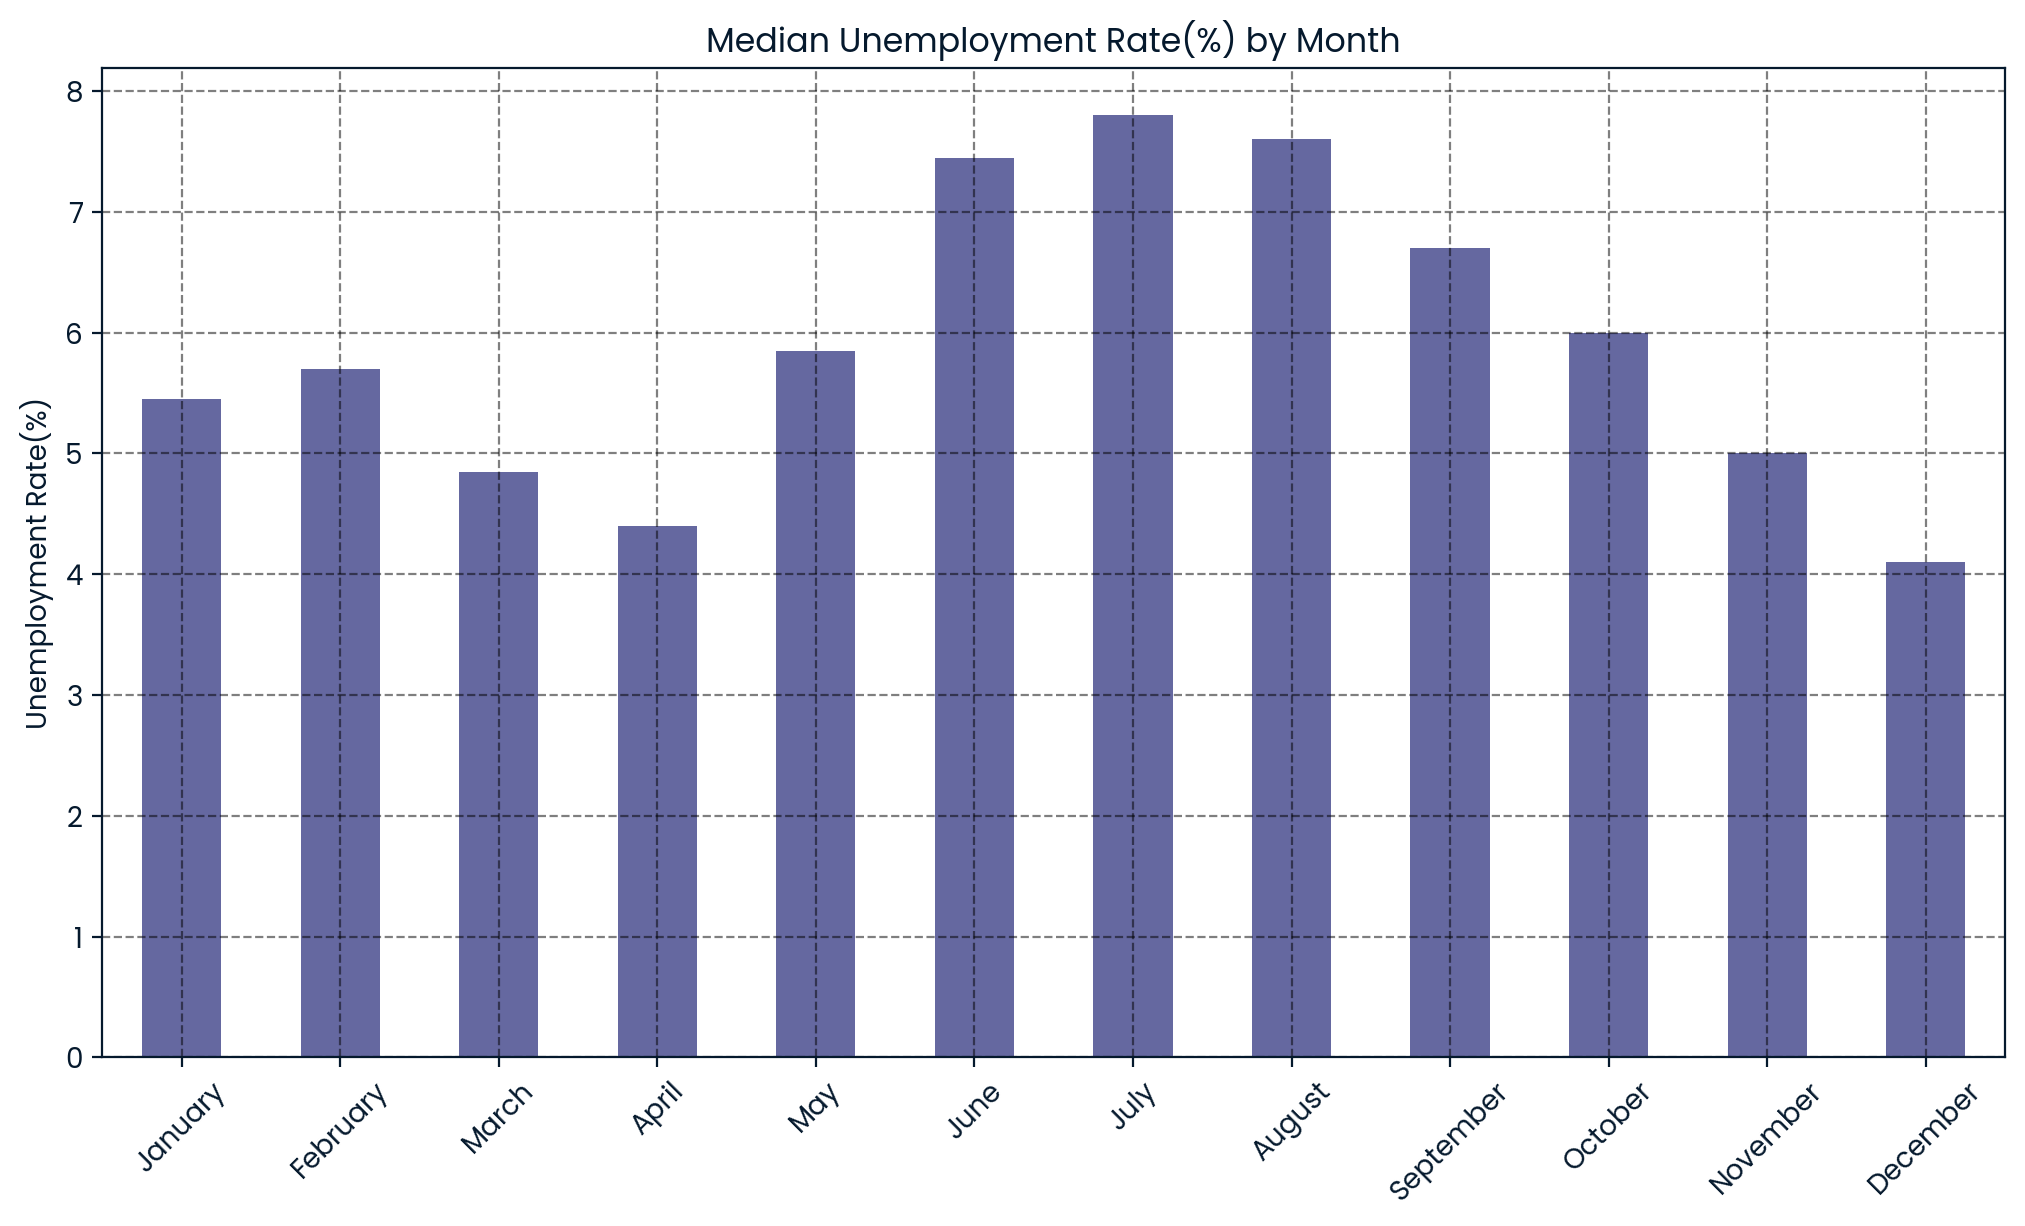

In [8]:
# Create the plot
ax = unemp.groupby(unemp.index.month).median().plot(kind='bar', figsize=(10,6))

ax.set_xticks(range(12))  # 0 to 11 for months
ax.set_xticklabels([calendar.month_name[i+1] for i in range(12)], rotation=45)

plt.tight_layout()
plt.title("Median Unemployment Rate(%) by Month")
plt.ylabel("Unemployment Rate(%)")
plt.grid(alpha=0.5, color='k',linestyle='--')
plt.show()

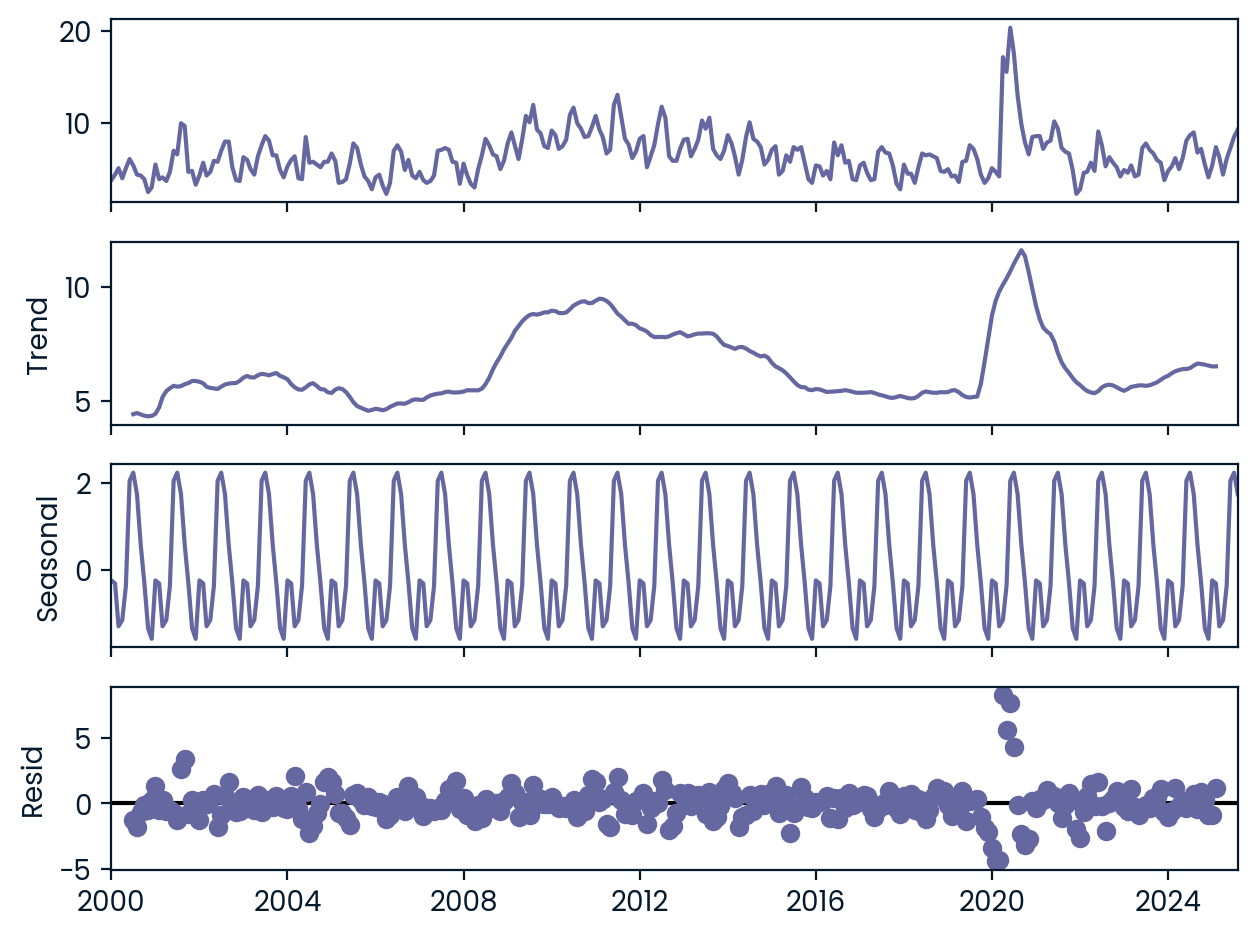

In [9]:
res = seasonal_decompose(unemp, period=12)
res.plot()

plt.show()

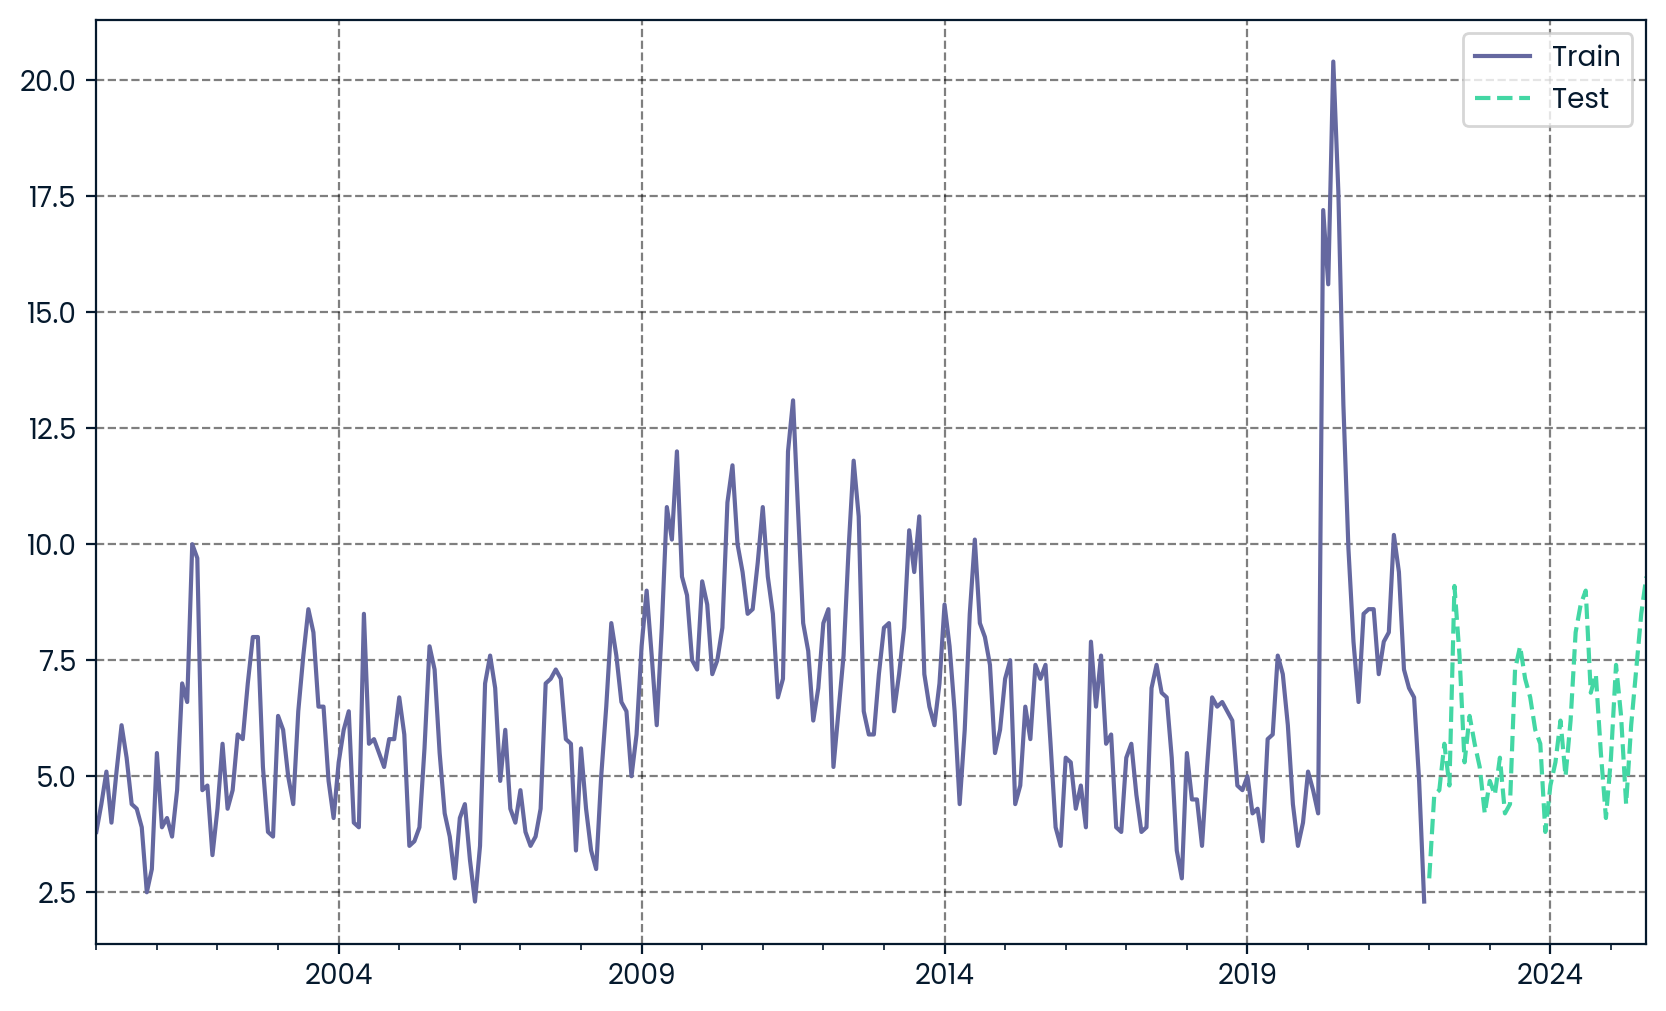

In [10]:
# Split data into training and test splits
train = unemp[:'2021']
test = unemp['2022':]

plt.figure(figsize=(10,6))
train.plot(label = "Train")
test.plot(linestyle = '--', label = "Test")

plt.legend()
plt.grid(alpha=0.5, color='k', linestyle ='--')
plt.show()

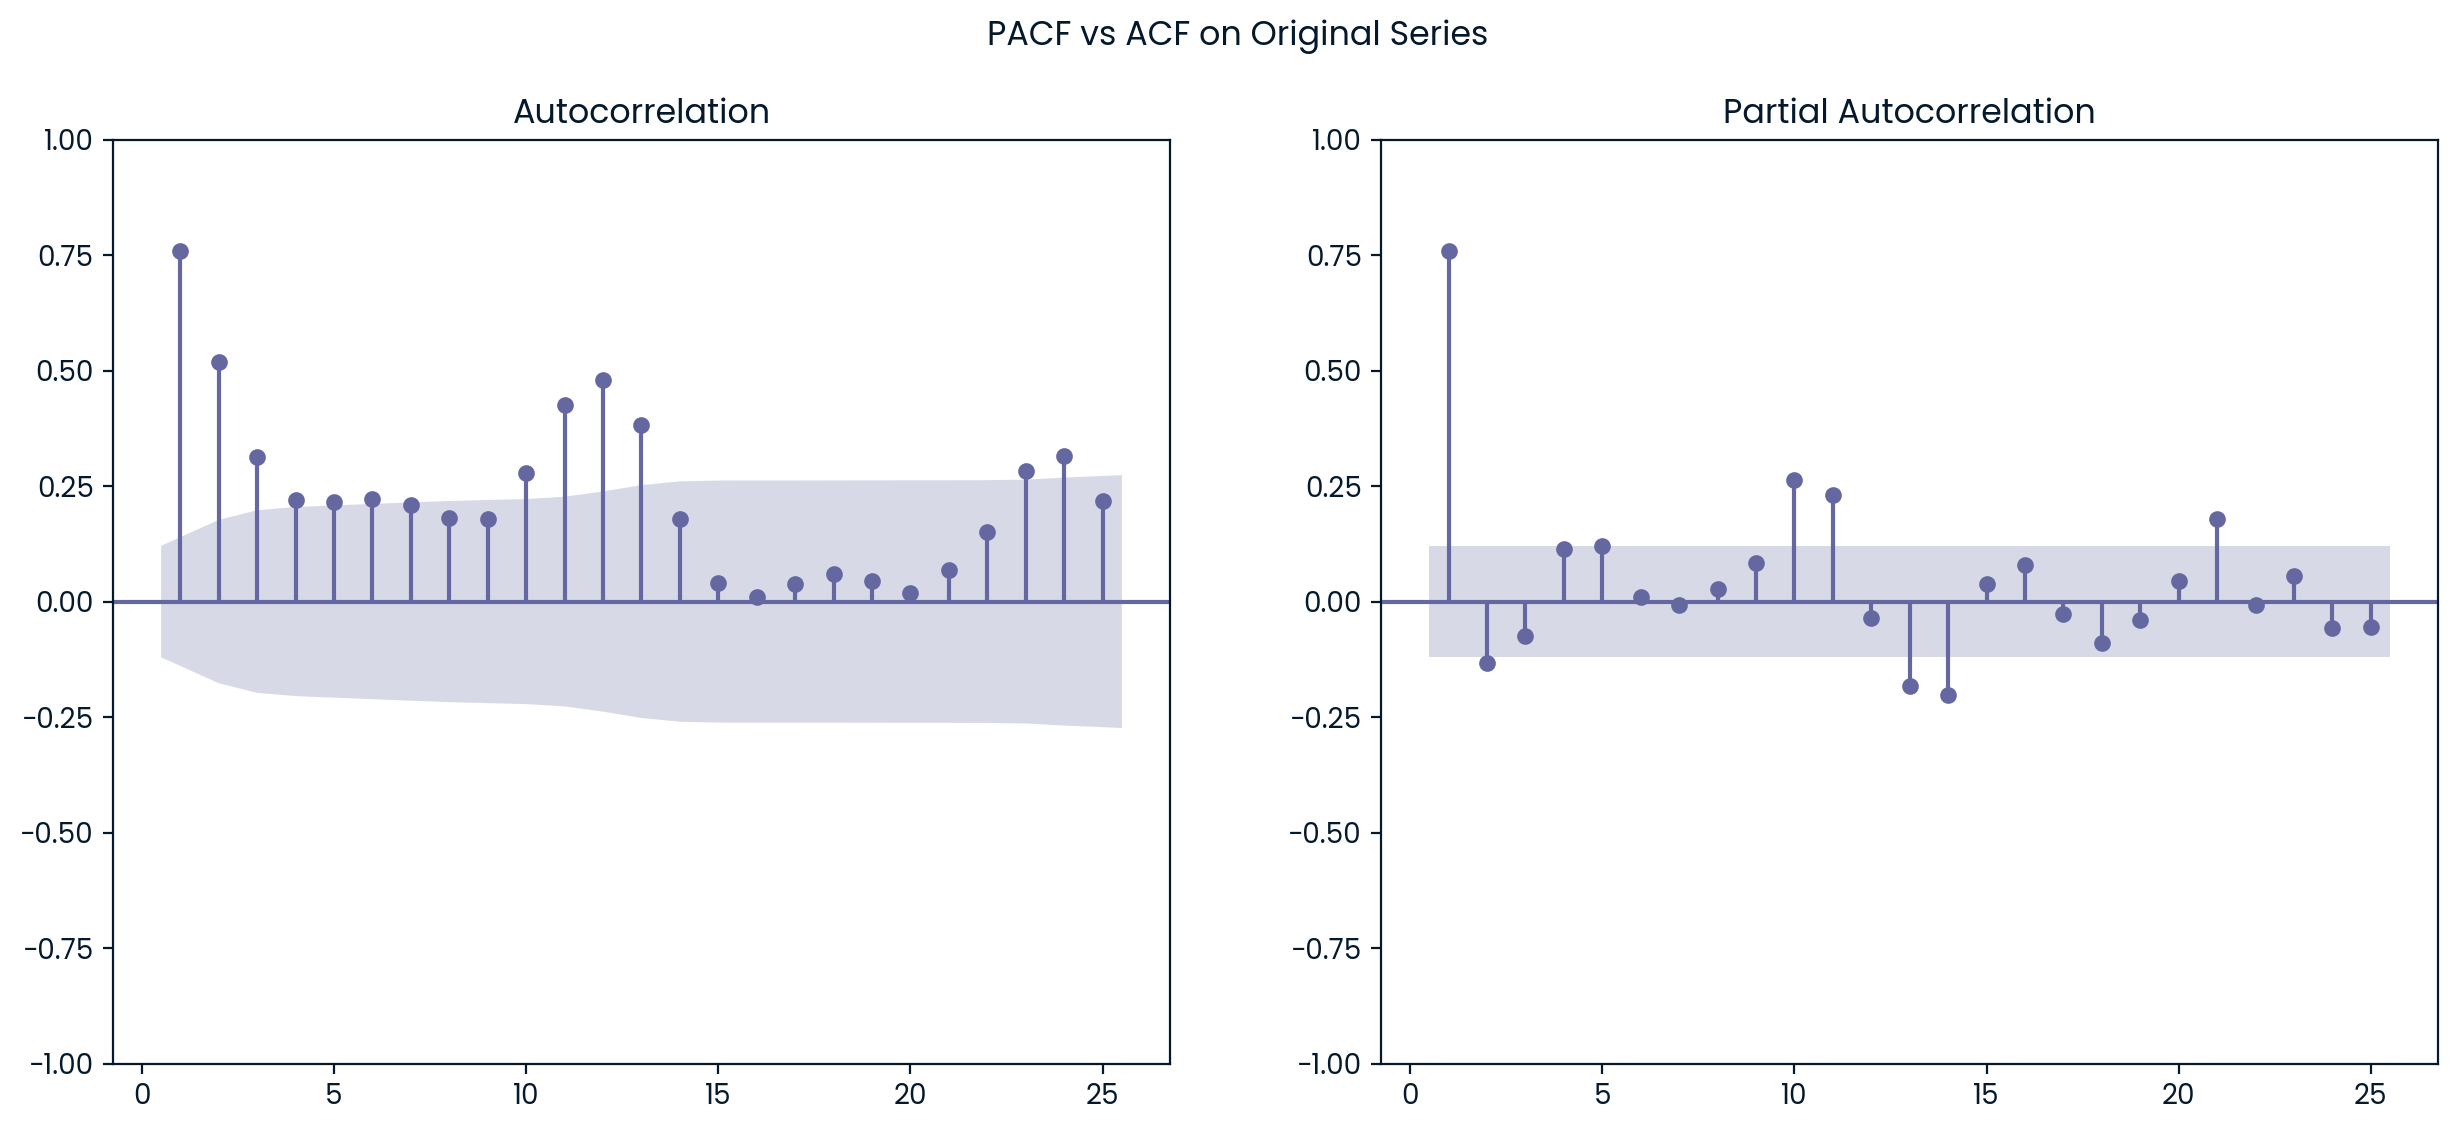

In [11]:
# Try to figure out seasonality trends
fig, ax = plt.subplots(1,2, figsize=(15,6))

plot_acf(train, ax=ax[0], zero=False);
#ax[0].set_title("ACF Plot\n(On Original Series)")

plot_pacf(train, ax=ax[1], zero=False);
#ax[1].set_title("PACF Plot\n(On Original Series)")

fig.suptitle("PACF vs ACF on Original Series")
plt.show()

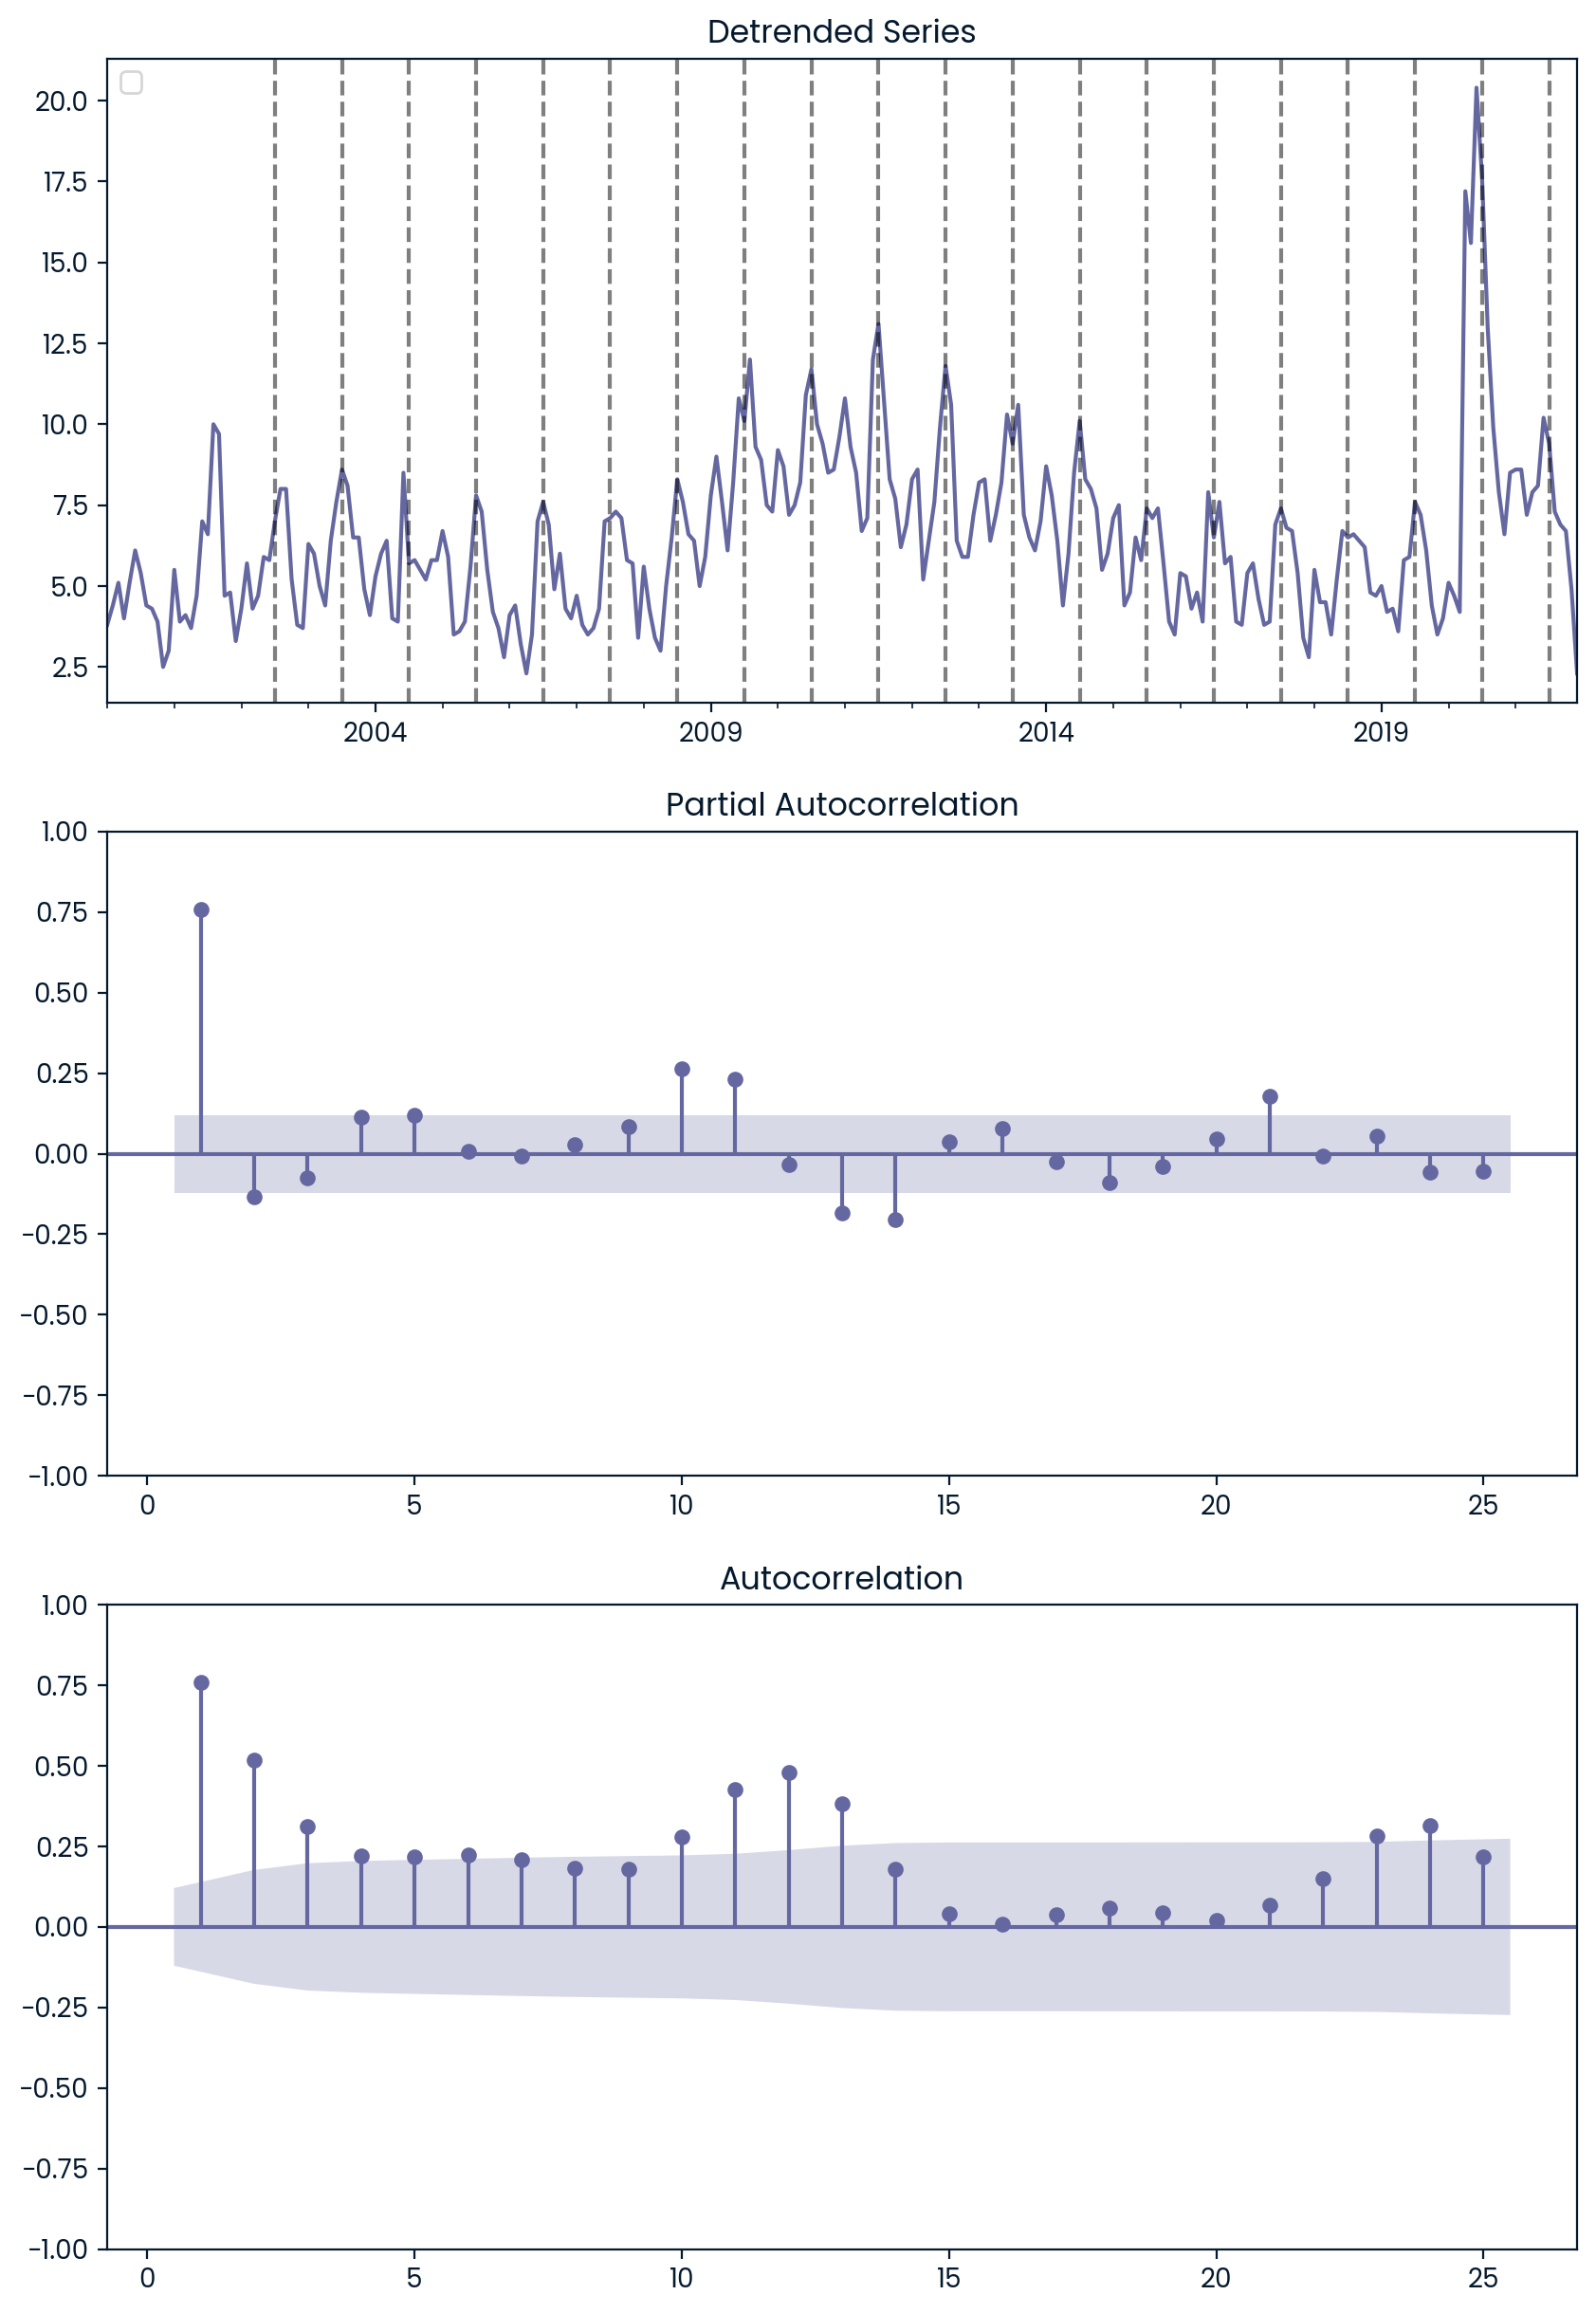

In [12]:
# Detrend time series
train_detrend = (train - train.rolling(24).mean()).dropna()

fig,ax = plt.subplots(3,1, figsize=(10, 15))
train.plot(ax=ax[0], title="Detrended Series")
for i, d in enumerate(train_detrend.index):
    if d.month == 7:
        lab = "July" if i == 0 else None
        ax[0].axvline(x=d, alpha=0.5, color='k', linestyle='--',
                      label=lab)
ax[0].legend()


plot_pacf(train, ax=ax[1], zero=False);
plot_acf(train, ax=ax[2], zero=False);

ax[0].legend()

plt.show()

In [13]:
# ROLLING FORECAST ORGIN
preds = []
lower_ci = []
upper_ci = []
history = train.copy()

for t in range(len(test)):
    # Fit model on all data up to this point
    model = SARIMAX(
        history,
        order=(1, 0, 1),
        seasonal_order=(0, 1, 0, 12)
    ).fit(disp=False)
    
    # Forecast one step ahead
    yhat = model.forecast(steps=1)[0]
    conf_int = model.get_forecast(steps=1).conf_int()  

    preds.append(yhat)
    lower_ci.append(conf_int.iloc[0, 0])
    upper_ci.append(conf_int.iloc[0, 1])
    # Update history with actual observed test value
    history = pd.concat([history, pd.Series([test.iloc[t]], index=[test.index[t]])])

# Convert predictions to a pandas Series
preds = pd.Series(preds, index=test.index)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so

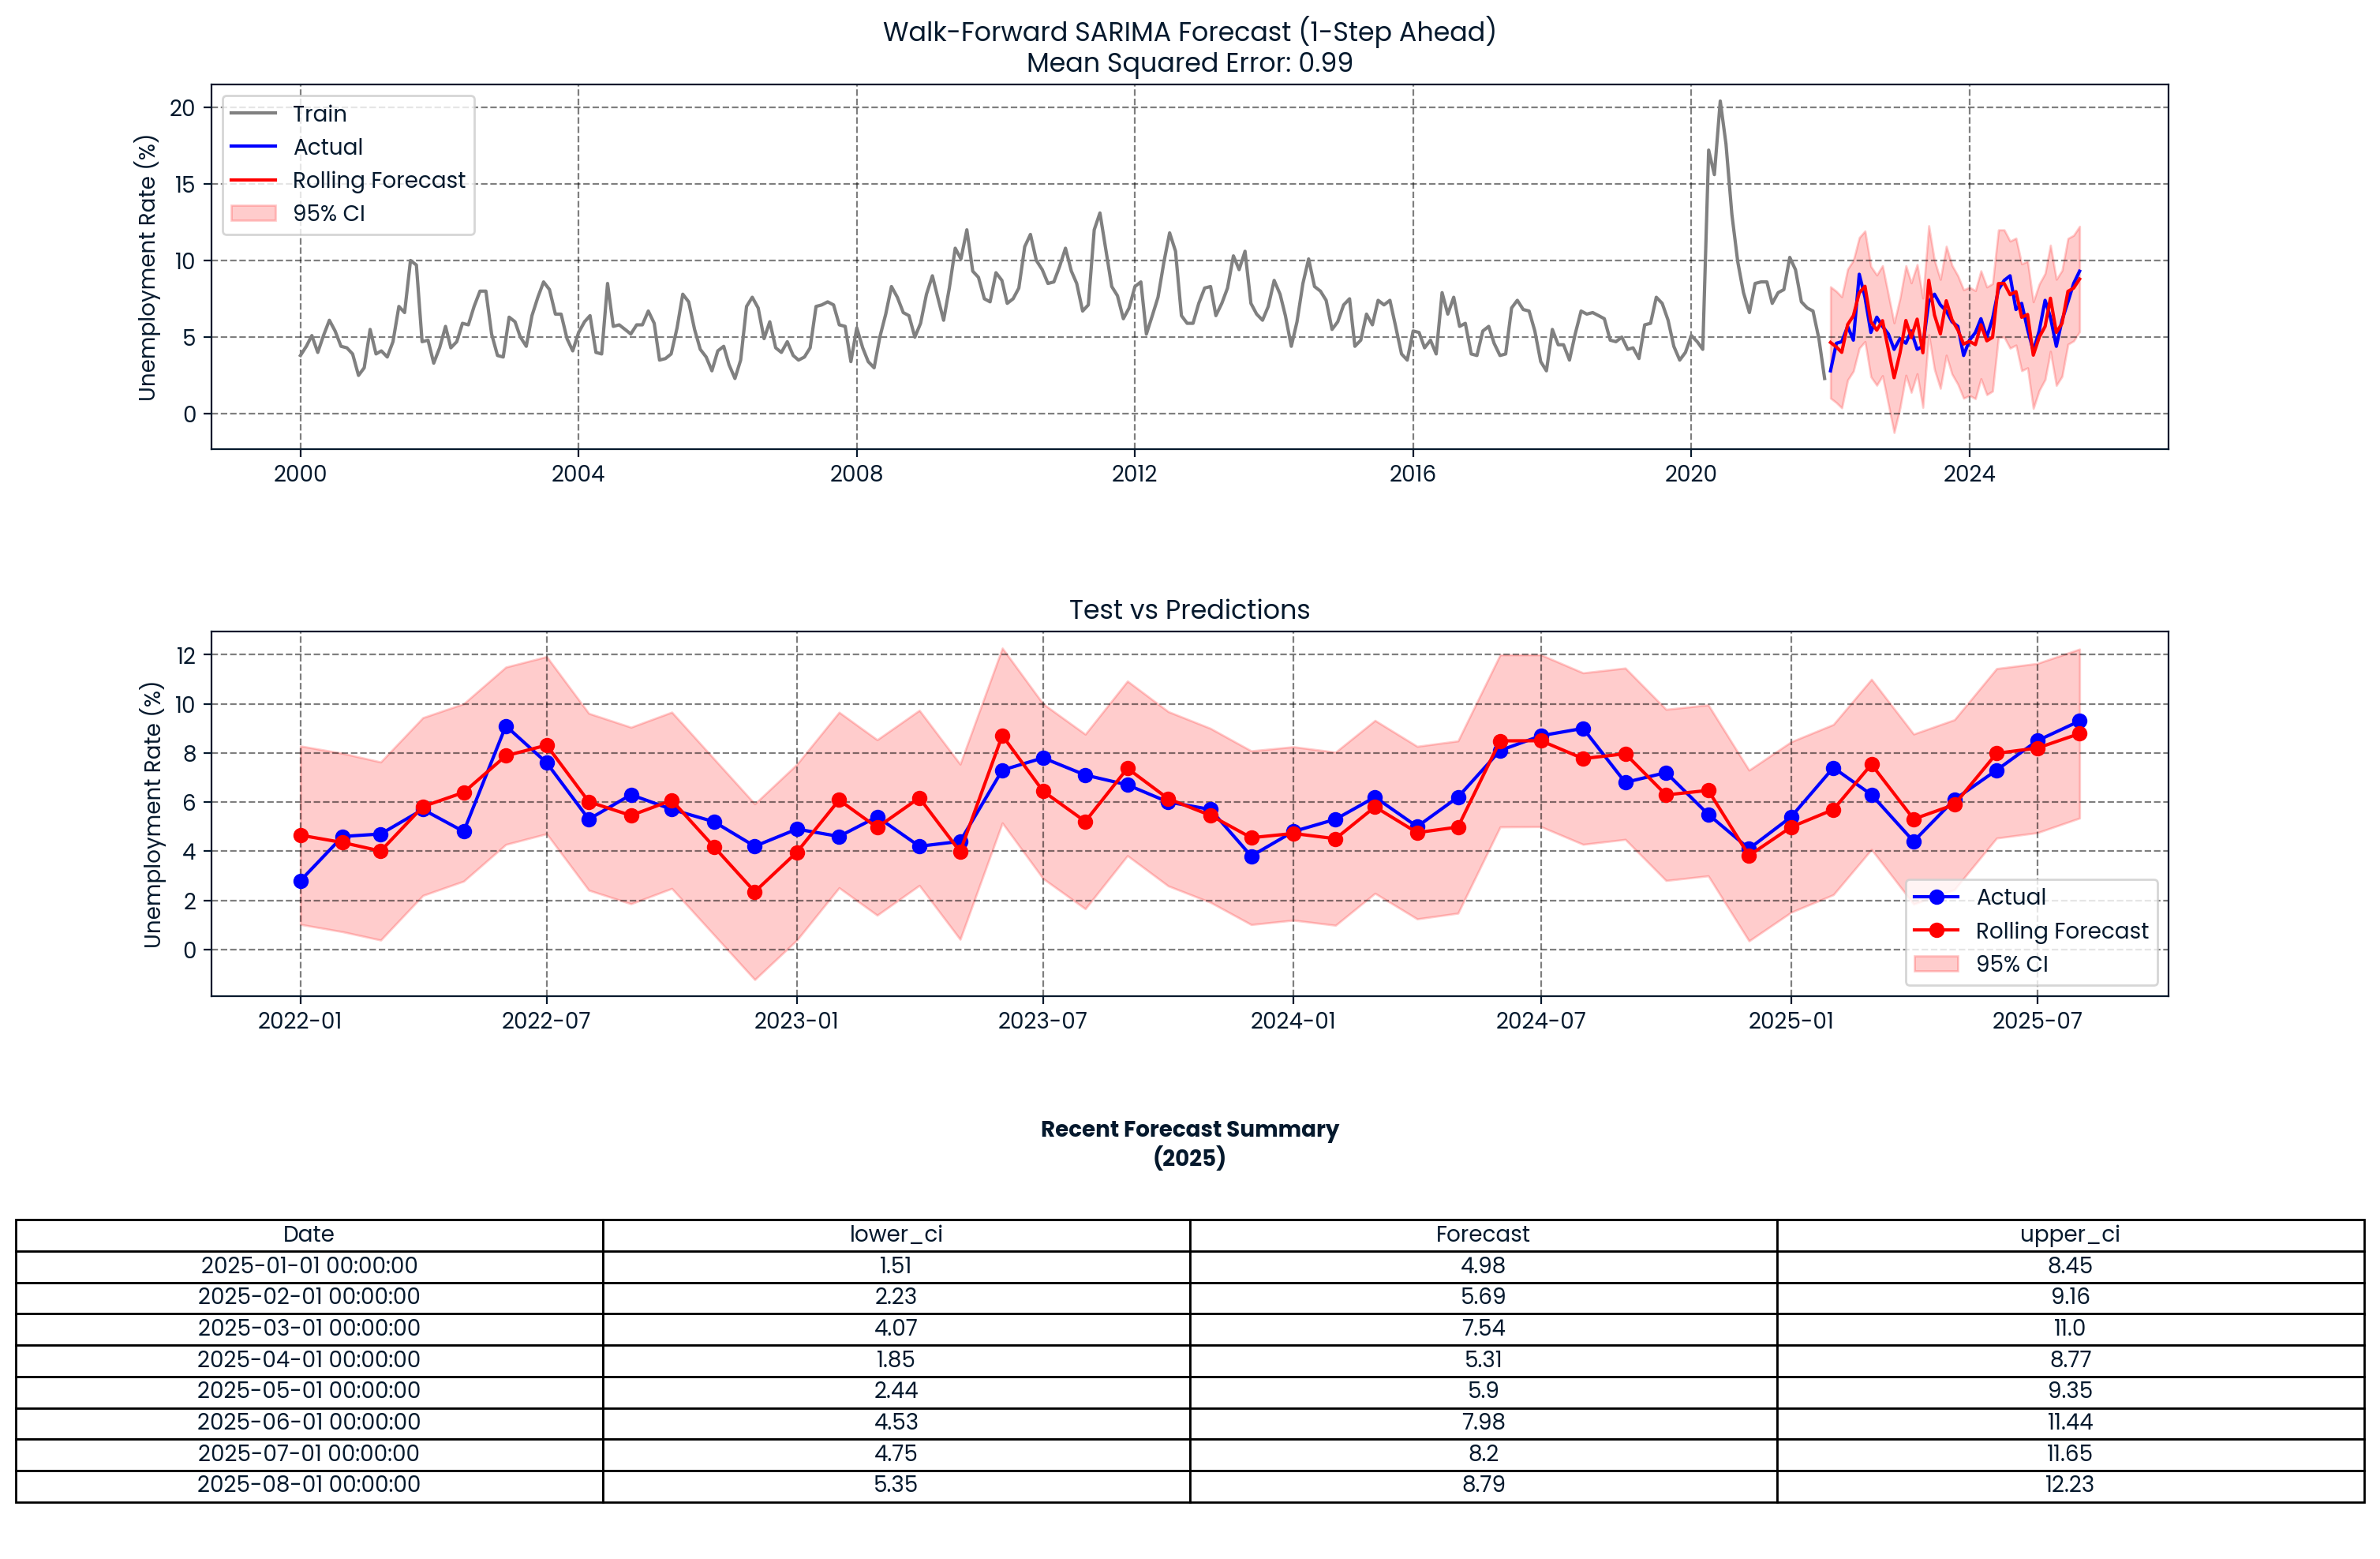

In [34]:
# Convert to Series for plotting
preds = pd.Series(preds, index=test.index)
lower_ci = pd.Series(lower_ci, index=test.index)
upper_ci = pd.Series(upper_ci, index=test.index)

# ---- Plot ----
fig, ax = plt.subplots(3, 1, figsize=(16,12))

# --- Top plot: full train/test split ---
ax[0].plot(train.index, train, label='Train', color='gray')
ax[0].plot(test.index, test, label='Actual', color='blue')
ax[0].plot(preds.index, preds, label='Rolling Forecast', color='red')
ax[0].fill_between(test.index, lower_ci, upper_ci, color='red', alpha=0.2, label='95% CI')
ax[0].set_title(f"Walk-Forward SARIMA Forecast (1-Step Ahead)\nMean Squared Error: {round(mean_squared_error(test, preds), 2)}")
ax[0].legend()
ax[0].grid(alpha=0.5, linestyle='--', color='k')
ax[0].set_ylabel("Unemployment Rate (%)")

# --- Bottom plot: zoom in on test period ---
ax[1].plot(test.index, test, label='Actual', color='blue', marker='o')
ax[1].plot(preds.index, preds, label='Rolling Forecast', color='red', marker='o')
ax[1].fill_between(test.index, lower_ci, upper_ci, color='red', alpha=0.2, label='95% CI')
ax[1].set_title("Test vs Predictions")
ax[1].grid(alpha=0.5, linestyle='--', color='k')
ax[1].set_ylabel("Unemployment Rate (%)")
ax[1].legend()

# Draw the table
pred_df = pd.concat([lower_ci, preds, upper_ci], axis=1)
pred_df = pred_df.reset_index()

pred_df.columns = ["Date", "lower_ci", "Forecast", "upper_ci"]

table_df = pred_df.tail(8).round(2)

ax[2].axis('off')
table = ax[2].table(cellText=table_df.values,
                    colLabels=table_df.columns,
                    cellLoc='center',
                    loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.4)
ax[2].set_title("Recent Forecast Summary\n(2025)", fontsize=10, weight='bold')

plt.subplots_adjust(hspace=0.5)
plt.show()

In [70]:
# Lets add in the last data point to make futre forecasts(outside of the test set)
model = SARIMAX(
    history,
    order=(1, 0, 1),
    seasonal_order=(0, 1, 0, 12)
).fit(disp=False)


forecast_res = model.get_forecast(steps=4)
forecast_mean = forecast_res.predicted_mean
forecast_ci = forecast_res.conf_int()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



In [71]:
forecast_mean.index = forecast_mean.index.strftime('%Y-%m-%d')
forecast_ci.index = forecast_ci.index.strftime('%Y-%m-%d')
forecast_mean

2025-09-01    6.940764
2025-10-01    7.310339
2025-11-01    5.586490
2025-12-01    4.167795
Name: predicted_mean, dtype: float64

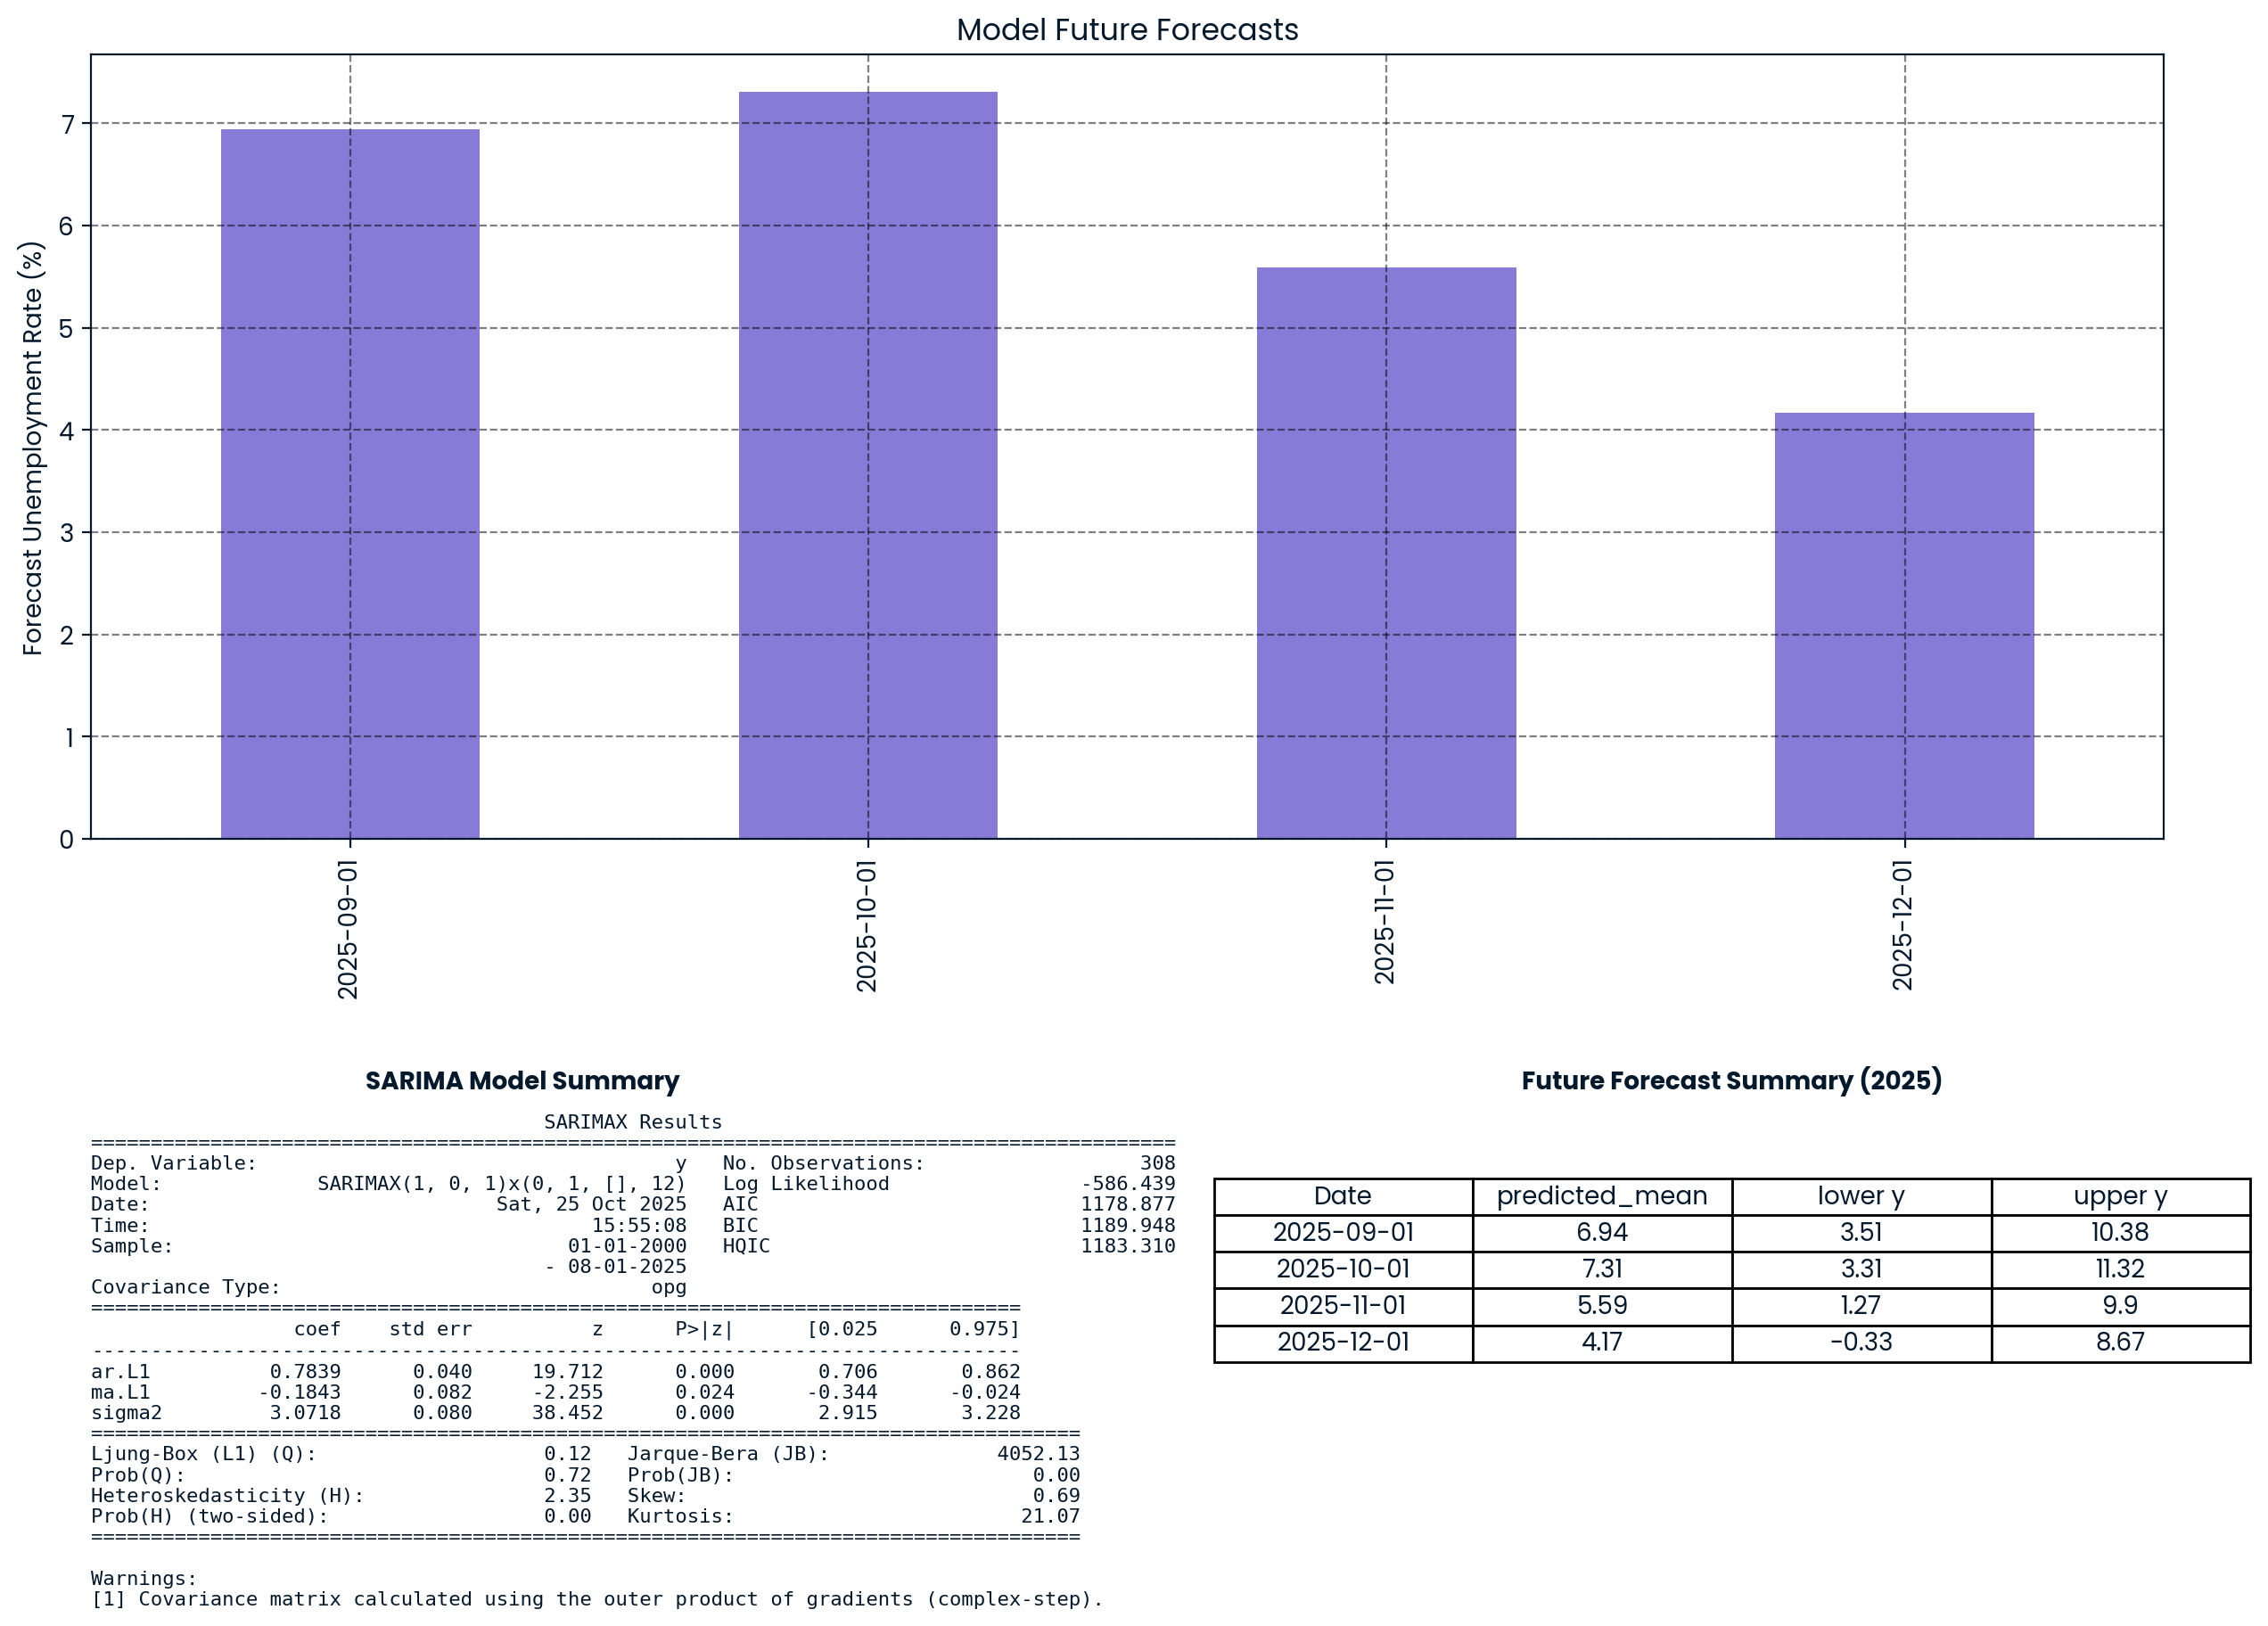

In [73]:
plt.figure(figsize=(15, 10))

# --- Layout: top = full width, bottom = two side-by-side ---
gs = plt.GridSpec(2, 2, height_ratios=[2.5, 1])

ax1 = plt.subplot(gs[0, :])   # full-width bar chart
ax2 = plt.subplot(gs[1, 0])   # model summary
ax3 = plt.subplot(gs[1, 1])   # forecast table

# --- Top plot ---
forecast_mean.plot(kind='bar', ax=ax1, color='slateblue', alpha=0.8)
ax1.grid(color='k', linestyle='--', alpha=0.5)
ax1.set_ylabel("Forecast Unemployment Rate (%)")
ax1.set_title("Model Future Forecasts")

# --- Model summary ---
ax2.axis('off')
summary_text = model.summary().as_text()
ax2.text(0, 1, summary_text, fontsize=8, family='monospace', va='top', ha='left')
ax2.set_title("SARIMA Model Summary", fontsize=10, weight='bold', pad=10)

# --- Forecast summary table ---
ax3.axis('off')
forecast_df = pd.concat([forecast_mean, forecast_ci], axis=1).reset_index()
forecast_df = forecast_df.rename(columns={'index':'Date'}).round(2)

table = ax3.table(
    cellText=forecast_df.values,
    colLabels=forecast_df.columns,
    cellLoc='center',
    loc='center'
)
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.4)
ax3.set_title("Future Forecast Summary (2025)", fontsize=10, weight='bold', pad=10)

plt.subplots_adjust(hspace=0.5, wspace=0.4)
plt.show()


In [20]:
# Prophet model